# TOC

__Chapter 3 - Diving deep into neural networks__

1. [Import](#Import)
1. [Layers – fundamental blocks of neural networks](#Layers–fundamental-blocks-of-neural-networks)
1. [Non-linear activations](#Non-linear-activations)
    1. [Sigmoid](#Sigmoid)
    1. [Tanh](#Tanh)
    1. [ReLU](#ReLU)
    1. [Leaky ReLU](#Leaky-ReLU)
1. [The PyTorch way of building deep learning algorithms](#The-PyTorch-way-of-building-deep-learning-algorithms)
1. [Loss functions](#Loss-functions)
1. [Optimizing network architecture](#Optimizing-network-architecture)
1. [Image classification using deep learning](#Image-classification-using-deep-learning)
    1. [Loading data into PyTorch tensors](#Loading-data-into-PyTorch-tensors)
    1. [Building the network architecture](#Building-the-network-architecture)
    1. [Training the model](#Training-the-model)

# Import

<a id = 'Import'></a>

In [31]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from PIL import Image
from glob import glob
import warnings
import time

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# pytorch tools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# Layers – fundamental blocks of neural networks


PyTorch users built-in functionality referred to as layers to perform high-level operations in the execution of a neural network framework. There are many different types of layers. The linear layer, for example, applies the following linear transformation:

$$
\textbf{Y} = \textbf{W}\textbf{x} + \textbf{b}
$$

Multiple layers can be executed in sequence.

<a id = 'Layers–fundamental-blocks-of-neural-networks'></a>

In [2]:
# this linear function layer accepts a tensor of size 1- and outputs a tensor of size 5 after
# applying a linear transformation
my_layer = nn.Linear(in_features=10, out_features=5, bias=True)
my_layer

Linear(in_features=10, out_features=5, bias=True)

In [3]:
# feed tensor of random numbers into my_layer
inp = Variable(torch.randn(1, 10))
my_layer = nn.Linear(in_features=10, out_features=5, bias=True)
my_layer(inp)

tensor([[-0.7086, -0.1205, -0.9051, -1.0967,  0.6616]],
       grad_fn=<AddmmBackward>)

In [4]:
# review weights - a 5 row by 10 column matrix reprsenting the 50 connections between the 10 input
# nodes and 5 output nodes
my_layer.weight

Parameter containing:
tensor([[ 0.2449,  0.1069, -0.1849,  0.1653, -0.0121, -0.3121, -0.1814,  0.0185,
          0.0796,  0.0297],
        [-0.2431, -0.0213,  0.0593,  0.2246, -0.2073,  0.0740,  0.0861,  0.0138,
         -0.0178, -0.2155],
        [ 0.1441,  0.2732, -0.1154, -0.0170,  0.1057, -0.2902, -0.1011, -0.2362,
         -0.1693,  0.2163],
        [-0.0602,  0.0039, -0.1447,  0.1729, -0.2520, -0.3117,  0.1530, -0.0229,
         -0.0712, -0.2182],
        [ 0.2585, -0.2851,  0.0659,  0.2062,  0.2105,  0.1708,  0.0648,  0.0845,
         -0.0954, -0.1660]], requires_grad=True)

In [5]:
# review biases - 1 bias unit for each output node
my_layer.bias

Parameter containing:
tensor([ 0.3072, -0.0937, -0.0228, -0.0854,  0.2804], requires_grad=True)

In [6]:
# create a network with multiple linear layers. NOTE - stacking two linear layer is not typically
# done in practice because linear transformation are unable to capture more complicated non-linear
# patterns
my_layer_1 = nn.Linear(10, 5)
my_layer_2 = nn.Linear(5, 2)
my_layer_2(my_layer_1(inp))

print("Layer 1 weights:\n")
print(my_layer_1.weight)

print("\nLayer 2 weights:\n")
print(my_layer_2.weight)

Layer 1 weights:

Parameter containing:
tensor([[-0.1660,  0.2410,  0.2126, -0.1319, -0.3130,  0.1258, -0.1921, -0.1989,
         -0.1423,  0.0679],
        [-0.0775, -0.1381,  0.1880, -0.0016,  0.1367,  0.1441, -0.0860, -0.2597,
         -0.0102,  0.0616],
        [-0.1437,  0.0607,  0.2579,  0.2038, -0.2483, -0.0836, -0.2426, -0.1593,
          0.0937, -0.1893],
        [-0.0304,  0.1431, -0.1982,  0.1349, -0.1198, -0.3113,  0.1254,  0.2749,
          0.1238,  0.0173],
        [ 0.1709, -0.0752,  0.0902,  0.2019,  0.2978, -0.3048, -0.2637,  0.2447,
         -0.2374,  0.1269]], requires_grad=True)

Layer 2 weights:

Parameter containing:
tensor([[ 0.0963,  0.0921,  0.3203, -0.2458,  0.1291],
        [ 0.4379,  0.0717, -0.0530, -0.0332,  0.2496]], requires_grad=True)


# Non-linear activations



<a id = 'Non-linear-activations'></a>

## Sigmoid

The sigmoid activation function takes the following form:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

It returns a number between 0 and 1. A large negative number returns a value close to zero, and a large positive number returns a value close to 1.

This function is not especially popular in modern implementations of neural networks because when the output of the sigmoid function is close to 0 or 1, the gradients for the layers are close to zero. Consequently, the learnable parameters of the previous layer get gradients close to zero and the weights do not get adjusted often. This results in 'dead' neurons.


<a id = 'Sigmoid'></a>

## Tanh

Similar to the sigmoid function, the tanh function also squashes real-valued inputs to a narrow range. The tanh range is -1 to 1. This activation function encounters the same issue as the sigmoid function when it handles extreme values close to -1 and 1. However, it is preferred to sigmoid because the output of tanh is centered at zero.

<a id = 'Tanh'></a>

## ReLU

ReLU is very popular activation function. It hsa the mathematical form:

$$
f(x) = max(0,x)
$$

ReLU squashes any input that is negative to an output value of zero, and leaves positive numbers as they are. Some pros of ReLU include:

- It helps the optimizer find the right weights sooner.
- It speeds up convergence of stochastic gradient descent
- It is computationally inexpensive, as we are simply thresholding rather than calculating.

A disadvantage of ReLU is that when a large gradient passes through it during backpropagation, the function can become non-responsive, resulting in a 'dead' neuron. This can be controlled by carefully choosing the model learning rate.

In [7]:
# simple illustration of ReLU activation
sample = Variable(torch.Tensor([[1, 2, -1, -1]]))
my_relu = nn.ReLU()
my_relu(sample)

tensor([[1., 2., 0., 0.]])

<a id = 'ReLU'></a>

## Leaky ReLU

Leaky ReLU attempts to solve the drawback of ReLU by insteading setting negative inputs to 0, it returns very small numbers suc as 0.001. It may provide superior performance but that is not guaranteed.

<a id = 'Leaky ReLU'></a>

In [8]:
# simple illustration of Learky ReLU activation
sample = Variable(torch.Tensor([[1, 2, -1, -1]]))
my_relu = nn.LeakyReLU()
my_relu(sample)

tensor([[ 1.0000,  2.0000, -0.0100, -0.0100]])

# The PyTorch way of building deep learning algorithms


All networks in PyTorch are implemented as classes by subclassing a PyTorch class called nn.Module. The class should also implement the init and forward methods. Inside the init function we initialize any layers, and the forward method passes our input data into the layer that were initialized in the init method before return the final output. The non-linear functions are often used in the forward function, and other time those function appear in the init method. Both are viable options depending on the use case.

The types of layers used, and the number of neurons in the various layers, are generally driven by the type of problem. If we are modelling a regression problem, the output layer will have one neuron, which will contain the predicted numeric value. If we are modelling a multiclass classification problem, the output layer will have a number of neurons equal to the number of unique classes in the target variable.

<a id = 'The-PyTorch-way-of-building-deep-learning-algorithms'></a>

In [9]:
# example PyTorch architecture. in the code below, super is used to pass arguments
# of the child class (nn.Module) to the parents class
class MyFirstNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyFirstNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def __forward__(self, input):
        out = self.layer1(input)
        out = nn.ReLU(out)
        out = self.layer2(out)
        return out

# Loss functions

With the network architecture in place, there are two important remaining steps. The first is calculating how well the nwtwork is performing, and the second is optimizing the model weights to improve the model of performance.

An optimizer accepts a scalar value, so the loss function needs to generate a scalar value, which is the value we are trying to minimize. In some use case, such as predicting where an obstacle is on the road and classifying whether or not that obstacle is a pedestrian or not, requires two or more loss functions. Even still, these loss function outputs would be combined to a single scalar for the optimizer to minimize.

We will begin by implementing a built-in loss function called Mean squared error. This is a basic loss funciton used in regression problems.

<a id = 'Loss-functions'></a>

In [10]:
# MSE loss function
loss = nn.MSELoss()
input = Variable(torch.randn(3, 5), requires_grad=True)
target = Variable(torch.randn(3, 5))
output = loss(input, target)
output.backward()

For classification problems, we use a corss-entropy loss. This loss function calculates the loss of a classification network by predicting the probabilities that an observation belongs to each class. Given that these are probabilities, the probabilities add up to 1. Cross-entropy loss increases when the predicted probability that an observation belongs to the correct class diverges from the correct probability. If the model makes a prediction similar to the actual label, the cross-entropy loss will be lower. In other words, if the predictions are bad, the loss will be high and if the predictions are good the loss will be low. Same as usual.

In [11]:
# custom cross-entropy loss function
def cross_entropy(true_label, predictions):
    if true_label == 1:
        return -log(prediction)
    else:
        return -log(1 - prediction)

In [12]:
# PyTorch implementation of cross-entropy
loss = nn.CrossEntropyLoss()
input = Variable(torch.randn(3, 5), requires_grad=True)
target = Variable(torch.LongTensor(3).random_(5))
output = loss(input, target)
output.backward()

A sample of other PyTorch loss functions include:

- L1 loss - used as a regularizer
- NLL loss - used for classification problems and allows us to use specific weights to handle imbalanced datasets
- NLL loss2d - Used for pixel-wise classification, mostly used for image segmentation problems.

# Optimizing network architecture

With the loss calculated, we need to optimize the weights to reduce the loss in each subsequent iteration of the learning process, and consequently improve the accuracy of the algorithm. Some optimizers include:

- ADADELTA
- Adagrad
- Adam
- SparseAdam
- Adamax
- ASGD
- LBFGS
- RMSProp
- Rprop
- SGD

Discussion regarding optimization algorithm specifics and pros and cons will follow in subsequent chapters.



<a id = 'Optimizing-network-architecture'></a>

In [14]:
# step involved in creating an optimizer
model = MyFirstNetwork(input_size=10, hidden_size=5, output_size=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


Once the optimizer is created, we need to call zero_grad() inside the loop to clear out the gradients calculated in the preivous optimizer call. loss.backward() calculates the gradients (quantity by which the weights/biases need to change), we call optimizer.step() which applies the changes to the weights/biases

```python
for input, target in dataset:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
  ```

# Image classification using deep learning



<a id = 'Image-classification-using-deep-learning'></a>

In [18]:
# ideally, the images are arranged in a way where there is a train and test folder, and within
# each of these folders is a subfolder for each class containg the respective images
path = "../../data/kaggleDogsVsCats/train"

# glob returns all files in the specified path. iglob is an alternative that creates a geneerator
# rather than pulling everything into memory
import shutil
from glob import glob

files = glob(os.path.join(path, "*.jpg"))
num_images = len(files)
print("Total number of images: {}".format(num_images))

# create a shuffled index for creating a validation dataset
shuffle = np.random.permutation(num_images)

# create directories with label names
for t in ["trainSubset", "validSubset"]:
    if not os.path.exists(os.path.join(localPath, t)):
        os.makedirs(os.path.join(localPath, t), exist_ok = True)
    for folder in ["dog", "cat"]:
        if not os.path.exists(os.path.join(localPath, t, folder)):
            os.mkdir(os.path.join(localPath, t, folder))

# copy a small subset of images to the validation folder
for i in shuffle[0:2000]:
    folder = files[i].split("/")[-1].split(".")[0]
    image = files[i].split("/")[-1]
    shutil.copy2(
        os.path.join(path, image), os.path.join(localPath, "trainSubset", folder)
    )

# copy a small subset of images to the training folder
for i in shuffle[2000:4001]:
    folder = files[i].split("/")[-1].split(".")[0]
    image = files[i].split("/")[-1]
    shutil.copy2(
        os.path.join(path, image), os.path.join(localPath, "validSubset", folder)
    )

Total number of images: 25000


## Loading data into PyTorch tensors

The PyTorch package torchvision.datasets provides a class called ImageFolder. It is common practice to perform the following preprocessing steps

1. Resize all images to the same size. In most deep learnin architectures this is expected.
2. Normalize the dataset with the mean and standard deviation of the dataset.
3. Convert the image dataset to a PyTorch tensor



<a id = 'Loading-data-into-PyTorch-tensors'></a>

In [19]:
# load images using the ImageFolder class
simple_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
train = datasets.ImageFolder("/main/tmp/DogsVsCats/trainSubset", simple_transform)
valid = datasets.ImageFolder("/main/tmp/DogsVsCats/validSubset", simple_transform)

In [20]:
# the train object holds all the image and associated labels. there are two important attributes: one
# that gives a mapping between class and the associated index in the dataset, and a second that gives a
# list of classes
print(train.class_to_idx)
print(train.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


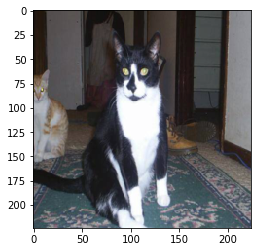

In [21]:
# visualize a sample of the data by reshaping and denormalizing the values
def imshow(inp):
    inp = inp.numpy().transpose([1, 2, 0])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


imshow(train[50][0])

In [22]:
# use the DataLoader class to return a batch of images. num_workers is used for parallelization. it is common
# practice to use a number of works fewer than the number of core available in the machine
train_data_gen = torch.utils.data.DataLoader(
    train, batch_size=64, num_workers=0, shuffle=True
)
valid_data_gen = torch.utils.data.DataLoader(valid, batch_size=64, num_workers=0)

In [23]:
# capture number of examples in train and validation datasets
dataset_sizes = {
    "train": len(train_data_gen.dataset),
    "valid": len(valid_data_gen.dataset),
}
print(dataset_sizes)

{'train': 2000, 'valid': 2001}


In [24]:
# load data objects into dictionary
dataloaders = {"train": train_data_gen, "valid": valid_data_gen}
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f80715c5780>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7f80715c5860>}


## Building the network architecture

PyTorch includes many prebuilt neural network architectures. ResNet is a popular deep learning algorithm that we will use in this example. The inner-workings of the algorithm will be covered in more detail in chapter 5. For now we will implement a model using the torchvision.models module.

When the argument 'pretrained' is set to True, the weights of the algorithm are already tuned for a particular ImageNet classification problem of predicting 1,000 different categories. It is already trained to predict the 1,000 ImageNet categories with a state-of-art level of accuracy. 

Since the weights are based on a particular classification task, we cannot use it directly. Generally speaking, algorithms tend to work better when started with fine-tuned weights rather than random weights, even if the use case is different, but we need to make adjustments. To tailor this for our use case, which involves predicting only one of two categories of dogs and cats, we alter the last layer of the ResNet model. This linear layer is changed such that the output only has 2 nodes.



<a id = 'Building-the-network-architecture'></a>

In [25]:
# implement ResNet. when the argument pretrained = True
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if torch.cuda.is_available():
    model_ft = model_ft.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:15<00:00, 3020601.72it/s]


In [26]:
# review model architecture
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## Training the model



<a id = 'Training-the-model'></a>

In [28]:
# create loss function based on cross-entropy and an optimizer based on SGD
# The StepLR function dynamically changes the learning rate
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [32]:
# function for running the model for several epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 30)

        # each epoch has a training and validation phase
        for phase in ["train", "valid"]:
            if phase == "train":
                scheduler.step()
                model.train(True)  # set model to training mode
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for data in dataloaders[phase]:
                # get inputs
                inputs, labels = data

                # wrap inputs and labels in a PyTorch Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs = Variable(inputs)
                    labels = Variable(labels)

                # zero out the gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training step
                if phase == "train":
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print("{} loss: {:.4f} acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best validation accuracy: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

The function above does the following:

- Passes the images through the model and calculates the loss
- Backpropagates during the training phase only. The validation phase does not involve weight adjustment
- The loss is accumulated across batches for each epoch
- the best moel is stored and validation accuracy is printed

In [33]:
# train model
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=7
)

Epoch 0/6
------------------------------
train loss: 0.0056 acc: 0.0000
valid loss: 0.0018 acc: 0.0000

Epoch 1/6
------------------------------
train loss: 0.0014 acc: 0.0000
valid loss: 0.0013 acc: 0.0000

Epoch 2/6
------------------------------
train loss: 0.0009 acc: 0.0000
valid loss: 0.0011 acc: 0.0000

Epoch 3/6
------------------------------
train loss: 0.0007 acc: 0.0000
valid loss: 0.0011 acc: 0.0000

Epoch 4/6
------------------------------
train loss: 0.0005 acc: 0.0000
valid loss: 0.0010 acc: 0.0000

Epoch 5/6
------------------------------
train loss: 0.0004 acc: 0.0000
valid loss: 0.0009 acc: 0.0000

Epoch 6/6
------------------------------
train loss: 0.0003 acc: 0.0000
valid loss: 0.0010 acc: 0.0000

Training complete in 34m 29s
Best validation accuracy: 0.000000
